# EDA Notebook
Import the data and take a look at different values.  Some information about the data. 

In [134]:
# Import Libaries
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
%matplotlib inline
plt.style.use('ggplot')
from matplotlib import colors
from matplotlib import gridspec
from matplotlib.ticker import StrMethodFormatter
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

### Import 38,000 wafers with defect lables
To maintain the balance between the various patterns of data, generative adversarial networks were used to generate some wafer maps to maintain the balance of the number of samples among the patterns. 

Mixed-type wafer map defect dataset can be used to identify mixed-type wafer map defect and assist the research on the causes of defects in the wafer manufacturing process.

MixedWM38 Dataset(WaferMap) has more than 38000 wafer maps, including 1 normal pattern, 8 single defect patterns, and 29 mixed defect patterns, a total of 38 defect patterns.

In [91]:
data = np.load('Wafer_Map_Datasets.npz')
# Could be better if we load from the web or use the LFS modue in Git
#data = np.load('https://drive.google.com/u/0/uc?id=1WBBFiYq-U9xYK83bk37COH6dHsXvLba5&export=download')

print(data.files)

['arr_0', 'arr_1']



## About the Data
[‘arr_0’]: Defect data of mixed-type wafer map, 0 means blank spot, 1 represents normal die that passed the electrical test, and 2 represents broken die that failed the electrical test. The data(ndarray) shape is (52, 52).

[‘arr_1’]: Mixed-type wafer map defect label, using one-hot encoding, a total of 8 dimensions, corresponding to the 8 basic types of wafer map defects (C2-C9).

In [92]:
# Build NP Arrays with wafer maps and defect lables
wafer_maps = data['arr_0']
defect_labels = data['arr_1']

In [93]:
# Check out size and shape.  38,015 records
print(wafer_maps.shape)
print(defect_labels.shape)

(38015, 52, 52)
(38015, 8)


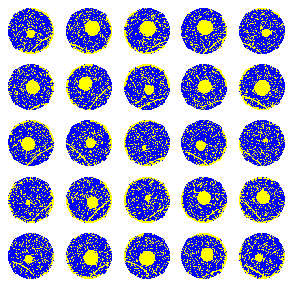

In [113]:
# Plot first 25 wafer maps
# Note: There are 25 wafers in a lot, so would be good to build a tool 
# that displays all wafer maps by lot

ax_cnt = 5

fig, axs = plt.subplots(ax_cnt, ax_cnt, figsize=(ax_cnt, ax_cnt))

# make a color map of fixed colors - blue passing die, yellow failing die
cmap = colors.ListedColormap(['white', 'blue', 'yellow'])
  
# Nested for loops to loop through all digits and number of examples input for ploting
for i in range(ax_cnt**2):
    # imshow to plot image in axs i,j loaction in plot
    axs[i%ax_cnt,int(i/ax_cnt)].imshow(wafer_maps[i], interpolation='none', cmap=cmap)
    axs[i%ax_cnt,int(i/ax_cnt)].axis('off') 


## How to turn wafer map data into best format for spacial defect signature recognition
- Leave as NP array - can we leave as 52x52 - should be able to, we did for digit recognition - go back to 207 HW1
- Turn into images and use YOLO
- Train on each of the defect classifiers and merge output
- Train on all classifers at same time

### Take a look at the labels
There are 38 types in the mixed-type wafer map defect dataset, including 1 normal type, 8 single defect types, and 29 mixed-type defect types.

#### Single Defect Types:
- Normal (N)-      [0 0 0 0 0 0 0 0]
- Center (C) -     [1 0 0 0 0 0 0 0]
- Donut (D) -      [0 1 0 0 0 0 0 0]
- Edge-Loc (EL) -  [0 0 1 0 0 0 0 0]
- Edge_Ring (ER) - [0 0 0 1 0 0 0 0]
- Loc (L) -        [0 0 0 0 1 0 0 0]
- Near_Full (NF) - [0 0 0 0 0 1 0 0]
- Scratch (S) -    [0 0 0 0 0 0 1 0]
- Random(R) -      [0 0 0 0 0 0 0 1]

See data description for more details and combinations.  

##### Next Steps
- Need to build some translations tables by convert digits in NP array into true categories, like the Cxx categories in .pdf.
- Then those labels can be use for training
- Can be done two ways:
    1. Train on all 38 mixed wafer types 
    2. Train on each defect type individually and then merge per wafer
- Once labels are created then perform some EDA to look for problems and data balance
- After that is done then can randomly break data set into training and test data and start w/ a few simple models

In [95]:
# Build Text Labels for ploting
text_labels = []
for label in defect_labels:
    string = ""
    if label[0] == 1:
        string += 'C'
    if label[1] == 1:
        string += 'D'
    if label[2] == 1:
        string += 'EL'
    if label[3] == 1:
        string += 'ER'
    if label[4] == 1:
        string += 'L'
    if label[5] == 1:
        string += 'NF'
    if label[6] == 1:
        string += 'S'
    if label[7] == 1:
        string += 'R'
    if string == "":
        string = 'N'
    text_labels.append(string)
    
       
# Get unique labels
# unique, counts = np.unique(defect_labels, return_counts=True)

# result = np.column_stack((unique, counts)) 
# print (result)

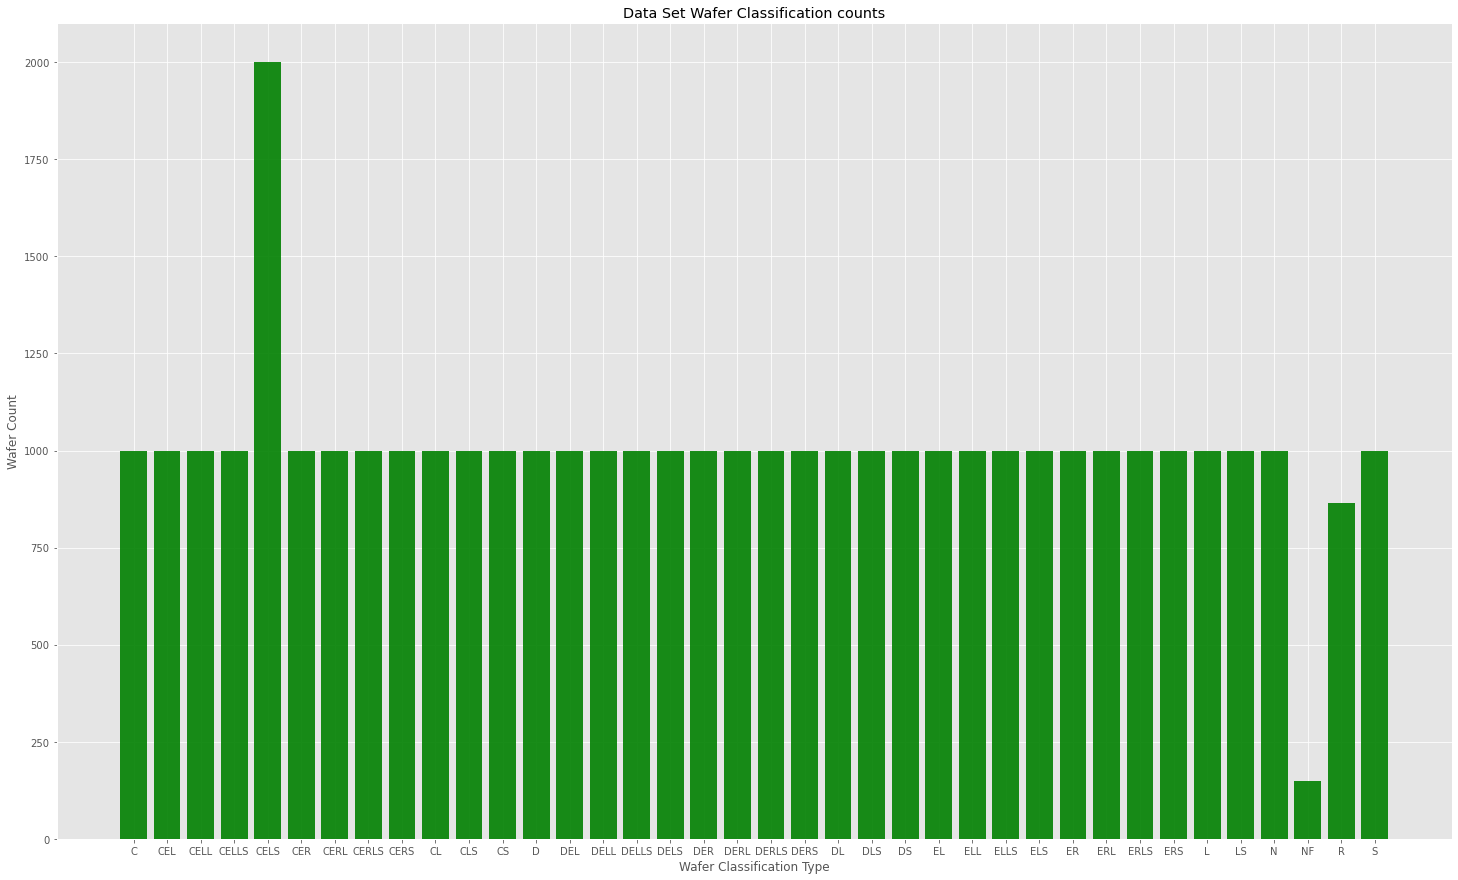

In [96]:
uni_pattern = np.unique(text_labels, return_counts=True)
plt.figure(figsize=(25, 15))
plt.bar(uni_pattern[0],uni_pattern[1], color = 'green', alpha=0.9)
plt.xlabel("Wafer Classification Type")
plt.ylabel("Wafer Count")
plt.title("Data Set Wafer Classification counts")
plt.show()


### Issues with Dataset
We know that in the real work that 'N' wafer would constitue < 90% of the wafers.  We also know that having an equal amount of each data type would not be the case either.  So we need to potentially use a GAN to generate data.

---------------------------



### Additional Dataset
Option to leverage the other dataset found here: https://www.kaggle.com/shawon10/wafer-defect-classification-by-deep-learning/data

Lets explore this dataset some.  Note: Code below is leveraged from Kaggle Notebook associated with this dataset.

In [97]:
df=pd.read_pickle("LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [98]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


In [99]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

C:\Users\scott\Anaconda3\lib\site-packages\pandas\core\internals\managers.py:1911: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


In [100]:
tol_wafers = df.shape[0]
tol_wafers

811457

In [101]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(172950, 25519, 147431)

C:\Users\scott\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


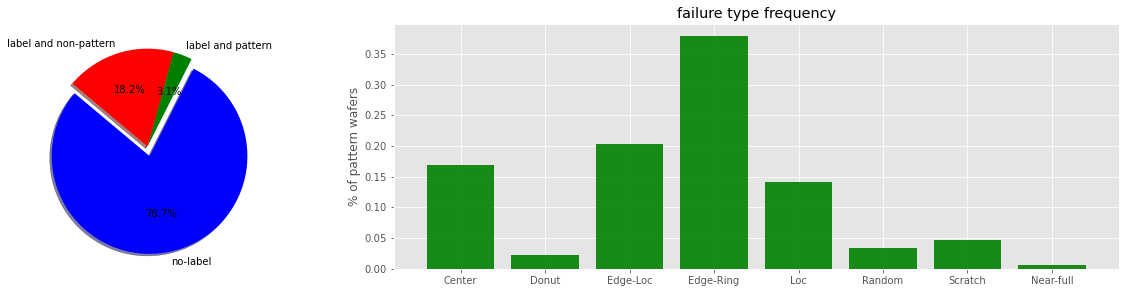

In [114]:
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

no_wafers=[tol_wafers-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

p_colors = ['blue', 'green', 'red']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['no-label','label and pattern','label and non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=p_colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='green', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

--------------------------------------
### Realistic Dataset
- Different products are running, making it more challenging training
- Failure types don't all match
- Includes Lot ID which should have common defect patterns and can be leverage in our GUI for displays
- This is more of what we'd expect with a real fab dataset where 80% of the wafers are random.

In [103]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]],8,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]],8,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]],8,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]],8,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]],8,0


In [107]:
df.waferMap[0]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [137]:
# Lets look at lotName
print('Lot Names:\n', df['lotName'])

Lot Names:
 0             lot1
1             lot1
2             lot1
3             lot1
4             lot1
            ...   
811452    lot47542
811453    lot47542
811454    lot47542
811455    lot47543
811456    lot47543
Name: lotName, Length: 811457, dtype: object


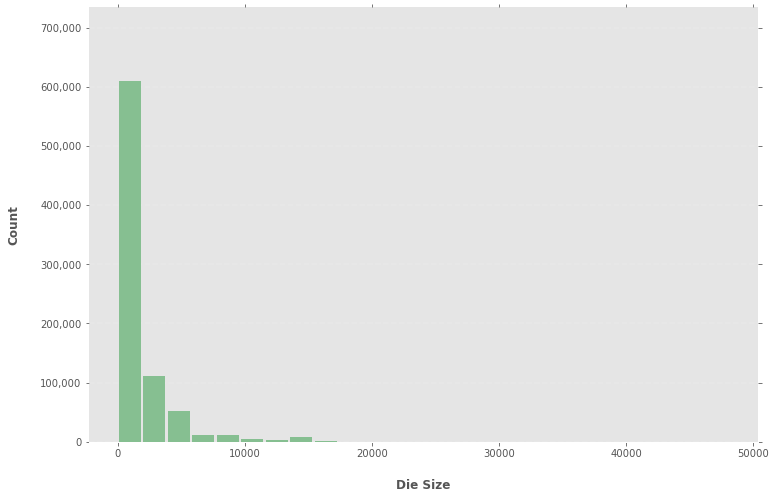

In [136]:
ax = df.hist(column='dieSize', bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Die Size", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Count", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

Enter Lot ID for display maps. Valid Lot ID range from 'lot1'-'lot47543': lot50
Lot ID Selected:  lot50


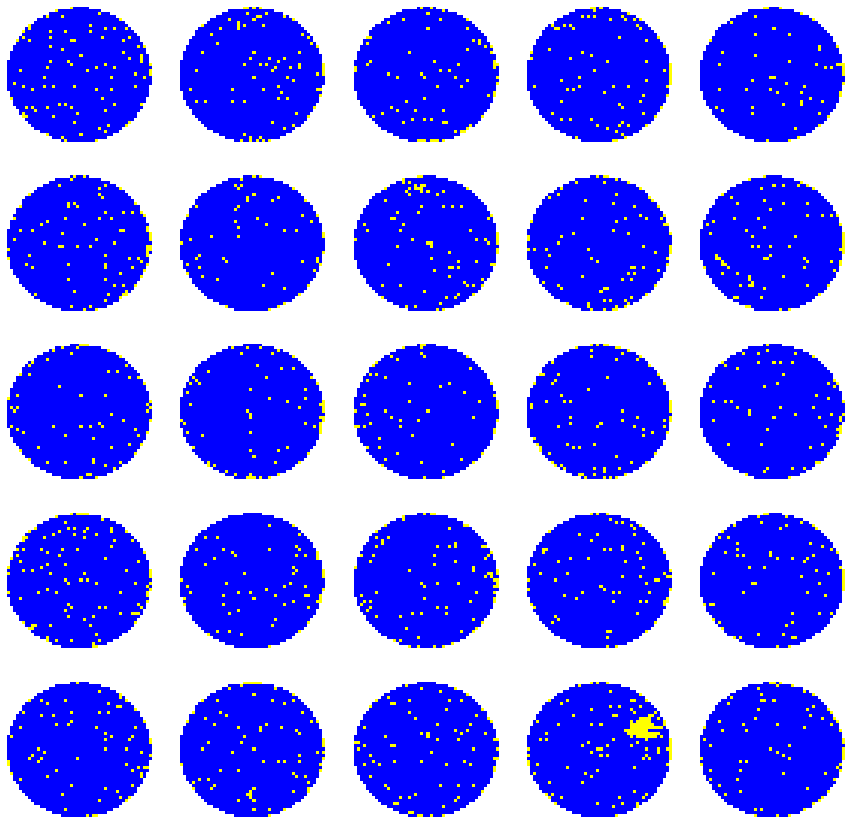

In [151]:
# Plot 25 wafer maps from selected lot
# Lots are from lot1-lot47543
# Note: There are 25 wafers in a lot, so would be good to build a tool 
# that displays all wafer maps by lot

lot = input("Enter Lot ID for display maps. Valid Lot ID range from 'lot1'-'lot47543': ")

print('Lot ID Selected: ', lot)

# selecting rows based on condition
lot_df = df[df['lotName'] == lot]

ax_cnt = 5

#fig, axs = plt.subplots(ax_cnt, ax_cnt, figsize=(ax_cnt, ax_cnt))
fig, axs = plt.subplots(ax_cnt, ax_cnt, figsize=(15, 15))


# make a color map of fixed colors - blue passing die, yellow failing die
cmap = colors.ListedColormap(['white', 'blue', 'yellow'])
  
# Nested for loops to loop through all digits and number of examples input for ploting
for i in range(ax_cnt**2):
    # imshow to plot image in axs i,j loaction in plot
    axs[i%ax_cnt,int(i/ax_cnt)].imshow(df.waferMap[i], interpolation='none', cmap=cmap)
    axs[i%ax_cnt,int(i/ax_cnt)].axis('off') 